# How to evaluate GAN

https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/  
https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a  
https://papers.nips.cc/paper_files/paper/2017/file/8a1d694707eb0fefe65871369074926d-Paper.pdf  



## Inception score (IS)

inception score는 ImageNet에서 pre train된 inception model을 이용하여 생성모델이 얼마나 다양하고, 잘 구분되는 샘플을 만드는지를 평가.  

inception model의 output을 이용하여 image에 대한 확률분포를 얻고 이를 이용하여 각 label에 대한 label distribution, 전체이미지에 대한 marginal distribution을 얻는다.

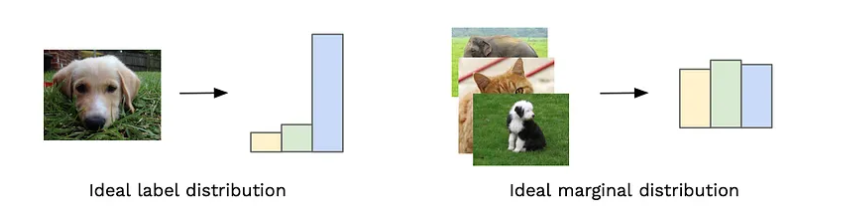

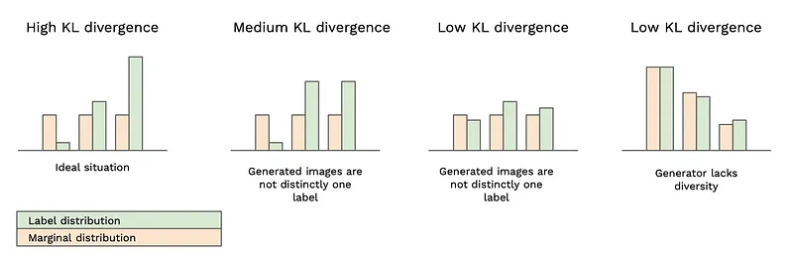

KL divergence를 이용하여 label 분포와 marginal 분포가 얼마나 유사한지를 측정  
> 높은 값이 나와야 다양한 이미지를 생성하면서 진짜같은 이미지를 생성한다는 뜻  

$$ IS(\mathbb{P}_g)  = \exp( \mathbb{E}_{x \sim \mathbb{P}_g} [D_{KL}(p(y|x)||p(y))] )$$

추가로 inception network의 weight에 민감하고, 다른 데이터셋으로 훈련된 모델에 IS를 적용시 잘못된 결과를 얻을 수 있고, class내에서 다양성을 측정할 수 없다는 한계점이 있음.

## Fréchet Inception Distance (FID)

마찬가지로 inception을 이용하여 측정  
inception의 출력 레이어 이전의 값 (2048 차원의 벡터)를 이용하여 실제 이미지와 생성 이미지의 특징을 비교  

실제 이미지와 생성된 이미지의 특징이 Gaussian을 따른다고 가정하면 두 분포 사이의 거리를 아래와 같이 계산

$$ d^2((m,C),(m_w,C_w)) = ||m-m_w||_2^2 + Tr(C+C_w-2(CC_2)^{1/2})$$  
$ m,C : $ 실제 데이터의 평균과 공분산  
$ m_w,C_W : $ 생성된 데이터의 평균과 공분산  

FID 값이 낮을수록 실제이미지와 비슷한 이미지를 생성한다는 의미. 평균적으로 FID가 10내외면 좋은 모델



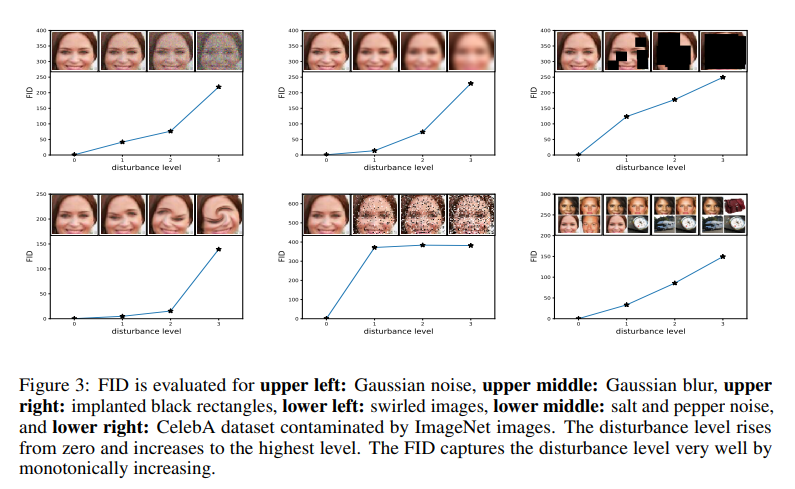

1번과 3번을 보면 FID가 3번에서 더 민감하게 반응  
1번과 4번을 보면 FID가 1번에서 더 민감하게 반응



# GAN evaluation

## Inception score (IS)


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/코드 이론/GAN/DCGAN')

from models import Generator_C, Generator
from dataloader import load_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
P = [0.1,0.1,0.3,0.5]
Q = [0.5,0.3,0.1,0.1]
KL = 0
for i in range(4):
  p,q = P[i],Q[i]
  KL += p * np.log(p/q)
KL

0.8634976227072619

In [ ]:
P = torch.tensor(P)
Q = torch.tensor(Q)
F.kl_div(Q.log(), P, reduction='sum')

tensor(0.8635)

In [ ]:
# load dataset

# dataset = load_dataset(299,128)
# x = next(iter(dataset))

In [ ]:
# load inception
class inception(nn.Module):
  def __init__(self, num_classes=102):
    super(inception, self).__init__()
    self.v3 = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
    self.v3.AuxLogits.fc = nn.Linear(768, num_classes)
    self.v3.fc = nn.Linear(2048, num_classes)
  def forward(self, x):
    return self.v3(x)

model = inception()
model.load_state_dict(torch.load('./incept_pt'))

<All keys matched successfully>

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = inception().to(device)
# optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))
# criterion = nn.CrossEntropyLoss()

# n_epochs = 5
# for epoch in range(n_epochs):
#   for img, label in dataset:
#     img, label = img.to(device), label.to(device)
#     optim.zero_grad()
#     outputs, aux_outputs = model(img)
#     loss1 = criterion(outputs, label)
#     loss2 = criterion(aux_outputs, label)
#     loss = loss1 + 0.4*loss2
#     loss.backward()
#     optim.step()
#   print('[Epoch %2d] [Loss %.4f]'%(epoch, loss.item()))

# torch.save(model.state_dict(),'./incept_pt')

In [ ]:
# load generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

G1 = Generator(100,64,3).to(device)
load_state = torch.load('./DCGAN_stand_2000')
G1.load_state_dict(load_state['G'])

G2 = Generator_C(100,32,3,64).to(device)
load_state = torch.load('./DCGAN_conv_500')
G2.load_state_dict(load_state['G'])

<All keys matched successfully>

In [ ]:
# inception score
def Inception_Score(G, model, num_samples=200,
                    device_f = torch.device('cuda')):
  with torch.no_grad():
    G = G.to(device_f)
    model = model.to(device_f)
    model.eval()
    z = torch.normal(0,1,(num_samples,100,1,1)).to(device_f)
    imgs = torchvision.transforms.Resize((299,299))(G(z))
    outs = model(imgs)
    probs = F.softmax(outs, dim=-1)
    marginal = probs.mean(dim=0)
    kl_sum = 0
    for i in range(num_samples):
      kl_sum += F.kl_div(marginal.log(), probs[i], reduction='sum')
  return np.exp(kl_sum.item()/num_samples) 

print('G1 : %.4f'%Inception_Score(G1, model))
print('G2 : %.4f'%Inception_Score(G2, model))

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


G1 : 1.4527
G2 : 1.3783


In [ ]:
with torch.no_grad():
  device = torch.device('cuda')
  z = torch.normal(0,2,(64,100,1,1)).to(device)
  img1 = torchvision.transforms.Resize((299,299))(G1(z).detach().cpu())
  grid1 = np.transpose(torchvision.utils.make_grid(img1, nrow=8, normalize=True),(1,2,0))
  img2 = torchvision.transforms.Resize((299,299))(G2(z).detach().cpu())
  grid2 = np.transpose(torchvision.utils.make_grid(img2, nrow=8, normalize=True),(1,2,0))
  imgs = np.concatenate([grid1, grid2], axis=1)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(imgs)
plt.title('convT vs conv')
plt.show()